In [1]:
import math
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt

Input values

In [176]:
#длина стола ширина стола
Lx = 2.0
Ly = 2.0 

# Координаты лузы
x0 = 1
y0 = 1

# Координаты красн. шарика
x1 = 1
y1 = 0.1

# Координаты зелен шарика
x2 = 1
y2 = 0.2

# Радиус лузы
R = 0.4

# Радиус шаров
r = 0.03

# Масса шаров
m = 0.3 

# начальная скорость кр шара
V0 = 2

g = 9.8
# к-т трения
mu1 = 0.03
mu2 = 0.15 
mu3 = 0.3

#mu1, mu2, mu3 = 0.1, 0.5, 1

#TODO
#alpha = math.pi/4
#mu = 0.1
#mu = mu3

Classes

In [177]:
class Coordinates:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def norm(self):
        return math.sqrt(self.x**2 + self.y**2) # ~ distance(Coordinates(0, 0))

    def distance(self, cord):
        #return math.sqrt(math.pow((cord.x - self.x ), 2) + math.pow((cord.y - self.y ), 2))
        return math.sqrt((self.x - cord.x)**2 + (self.y - cord.y)**2)
    
    def __add__(self, coordinates):
        return Coordinates(self.x + coordinates.x, self.y + coordinates.y)
    def __sub__(self, coordinates):
        return Coordinates(self.x - coordinates.x, self.y - coordinates.y)
    def __mul__(self, const):
        return Coordinates(const*self.x, const*self.y)
    def __rmul__(self, const):
        return Coordinates(const*self.x, const*self.y)
    def __truediv__(self, const):
        return Coordinates(self.x / const, self.y / const)
    def __lt__(self, coordinates):
        return self.x < coordinates.x or self.y < coordinates.y

class Ball:
    def __init__(self, coordinates : Coordinates, speed : Coordinates, acceleration : Coordinates, m, r):
        self.coordinates = coordinates
        self.setSpeed(speed)
        self.setAcceleration(acceleration)
        self.m = m
        self.r = r
    def setSpeed(self, speed):
        self.speed = deepcopy(speed)
        #if speed is not None:
        #    self.speed = Coordinates(speed.x ,speed.y)
    def getSpeed(self):
        return self.speed
    def setAcceleration(self, acceleration : Coordinates):
        self.acceleration = deepcopy(acceleration)
    def getAcceleration(self):
        return self.acceleration
    
    def iteration(self, dt):
        dv = dt*self.acceleration
        if abs(self.speed.x) < abs(dv.x):
            dv.x = -self.speed.x
        if abs(self.speed.y) < abs(dv.y):
            dv.y = -self.speed.y
        self.coordinates = self.coordinates + dt*self.speed
        self.speed = self.speed + dv

    def isCollision(self, ball):
        return self.coordinates.distance(ball.coordinates) <= self.r + ball.r
    
    def isCollisionWall(self, Lx, Ly):
        def is_collision_side(Lx):
            if self.coordinates.x + self.r >= Lx or self.coordinates.x - self.r <= 0:
                return -1
            else:
                return 1
        def is_collision_end(Ly):
            if self.coordinates.y + self.r >= Ly or self.coordinates.y - self.r <= 0:
                return -1
            else:
                return 1
        self.speed.x = self.speed.x * is_collision_side(Lx)
        self.speed.y = self.speed.y * is_collision_end(Ly)
        self.acceleration.x = self.acceleration.x * is_collision_side(Lx)
        self.acceleration.y = self.acceleration.y * is_collision_end(Ly)
        #_alpha = math.atan(self.speed.y / self.speed.x)
        #self.setAcceleration()

Main logic

In [185]:
results = {
    mu1 : dict(zip(np.linspace(0, 2*np.pi, 360).tolist(), [-1]*360)),
    mu2 : dict(zip(np.linspace(0, 2*np.pi, 360).tolist(), [-1]*360)),
    mu3 : dict(zip(np.linspace(0, 2*np.pi, 360).tolist(), [-1]*360))
}
#print(results)
dt = 10./2000
for mu, result in results.items():
    for alpha in result.keys():
        RedBall = Ball(Coordinates(x1, y1),\
                    Coordinates(V0*math.cos(alpha), V0*math.sin(alpha)),\
                        Coordinates(-mu*g*math.cos(alpha), -mu*g*math.sin(alpha)),\
                            m, r)
        GreenBall = Ball(Coordinates(x2, y2), Coordinates(0, 0), Coordinates(0, 0), m, r)
        Hole = Ball(Coordinates(x0, y0), None, None, None, R)
        for t in np.linspace(0, 10, 2000):
            if RedBall.isCollision(GreenBall):
                d = 0
                _alpha = 0
                if RedBall.speed.x != 0:
                    _alpha = math.atan(RedBall.speed.y / RedBall.speed.x)
                    if RedBall.speed.y > 0 and RedBall.speed.x < 0 or RedBall.speed.y < 0 and RedBall.speed.x < 0:
                        _alpha += math.pi
                    BR = RedBall.coordinates.y - RedBall.speed.y / RedBall.speed.x * RedBall.coordinates.x
                    BG = GreenBall.coordinates.y - RedBall.speed.y / RedBall.speed.x * GreenBall.coordinates.x
                    d = (BR - BG) / math.sqrt((RedBall.speed.y / RedBall.speed.x)**2 + 1)
                else:
                    if RedBall.speed.y > 0:
                        _alpha = math.pi / 2
                    else:
                        _alpha = -math.pi / 2
                    BR = RedBall.coordinates.x
                    BG = GreenBall.coordinates.x
                    d = BR - BG
                if abs(BR - BG) == 0: #центральное столкновение
                    GreenBall.setSpeed(RedBall.getSpeed())
                    GreenBall.setAcceleration(RedBall.getAcceleration())
                else:
                    phi = math.acos(abs(d)/(2*r))
                    if _alpha != math.pi / 2:
                        if (d > 0) == (RedBall.speed.x > 0): #A
                            phiRed = _alpha + phi
                            phiGreen = _alpha - (math.pi / 2 - phi)
                        else: #B
                            phiRed = _alpha - phi
                            phiGreen = _alpha + (math.pi / 2 - phi)
                    else:
                        if (BR < BG) == (RedBall.coordinates.x < GreenBall.coordinates.x):
                            phiRed = _alpha + phi
                            phiGreen = _alpha - (math.pi / 2 - phi)
                        else:
                            phiRed = _alpha - phi
                            phiGreen = _alpha + (math.pi / 2 - phi)
                    GBSpeedNorm = RedBall.speed.norm() * math.sin(_alpha - phiRed) / math.sin(phiGreen - phiRed)
                    GreenBall.setSpeed(Coordinates(GBSpeedNorm*math.cos(phiGreen),\
                                                GBSpeedNorm*math.sin(phiGreen)))
                    GreenBall.setAcceleration(Coordinates(-mu*g*math.cos(phiGreen), -mu*g*math.sin(phiGreen)))
                    RBSpeedNorm = RedBall.speed.norm() / math.cos(phiRed) * \
                        (math.cos(_alpha) - math.cos(phiGreen)*math.sin(_alpha - phiRed) / math.sin(phiGreen - phiRed))
                    RedBall.setSpeed(Coordinates(RBSpeedNorm*math.cos(phiRed), RBSpeedNorm*math.sin(phiRed)))
                    RedBall.setAcceleration(Coordinates(-mu*g*math.cos(phiRed), -mu*g*math.sin(phiRed)))
            if GreenBall.isCollision(Hole):
                result[alpha] = m * GreenBall.speed.norm()**2 / 2
                break
            if RedBall.speed.x == 0 and RedBall.speed.y == 0 and GreenBall.speed.x == 0 and GreenBall.speed.y == 0:
                break
            RedBall.isCollisionWall(Lx, Ly)
            GreenBall.isCollisionWall(Lx, Ly)
            RedBall.iteration(dt)
            GreenBall.iteration(dt)
            
    results[mu] = {angle:energy for angle, energy in result.items() if energy != -1}
    #result = {angle:energy for angle, energy in result.items() if energy != -1}

Graph

360


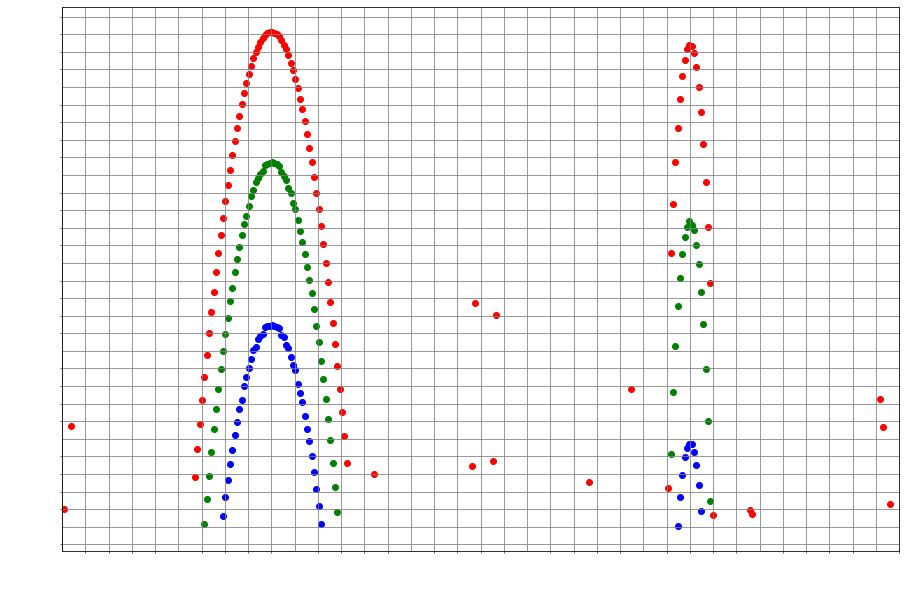

In [186]:
print(len(result))
color1 = 'white'
color2 = 'black'
color0 = color1


#angles = list(result.keys())
#E = list(result.values())
#angles = [angle * 180 / math.pi for angle in angles]

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot()
#plt.figure(figsize=(15, 10))
plt.minorticks_on()
plt.xlim((0, 360))
plt.grid(which='major', color = 'grey')
plt.grid(which='minor', color = 'grey')
plt.ylabel("Энергия шара $E$ (Дж)", fontsize=24, color=color0)
plt.xlabel("Угол $\\alpha$ (град)", fontsize=24, color=color0)
ax.tick_params(axis='x', colors=color0)
ax.tick_params(axis='y', colors=color0)
#plt.scatter(angles, E, color='r')
plt.scatter([angle * 180 / math.pi for angle in list(results[mu1].keys())], list(results[mu1].values()), color='r')
plt.scatter([angle * 180 / math.pi for angle in list(results[mu2].keys())], list(results[mu2].values()), color='g')
plt.scatter([angle * 180 / math.pi for angle in list(results[mu3].keys())], list(results[mu3].values()), color='b')
plt.grid(True)



plt.savefig('graph.jpg')
plt.show()

Test

In [193]:
mu = 0.03
dt = 10. / 200
alpha = math.pi / 2 + 0.1
RedBall = Ball(Coordinates(x1, y1),\
                Coordinates(V0*math.cos(alpha), V0*math.sin(alpha)),\
                    Coordinates(-mu*g*math.cos(alpha), -mu*g*math.sin(alpha)),\
                        m, r)
GreenBall = Ball(Coordinates(x2, y2), Coordinates(0, 0), Coordinates(0, 0), m, r)
Hole = Ball(Coordinates(x0, y0), None, None, None, R)
toSaveRed = [[], []]
toSaveGreen = [[], []]
for t in np.linspace(0, 10, 200):

    toSaveRed[0].append(RedBall.coordinates.x)
    toSaveRed[1].append(RedBall.coordinates.y)
    toSaveGreen[0].append(GreenBall.coordinates.x)
    toSaveGreen[1].append(GreenBall.coordinates.y)
    
    #print(RedBall.coordinates.distance(GreenBall.coordinates))
    #print(RedBall.coordinates.x, RedBall.coordinates.y)
    #print()
    if RedBall.isCollision(GreenBall):
        d = 0
        _alpha = 0
        if RedBall.speed.x != 0:
            _alpha = math.atan(RedBall.speed.y / RedBall.speed.x)
            if RedBall.speed.y > 0 and RedBall.speed.x < 0 or RedBall.speed.y < 0 and RedBall.speed.x < 0:
                _alpha += math.pi
            BR = RedBall.coordinates.y - RedBall.speed.y / RedBall.speed.x * RedBall.coordinates.x
            BG = GreenBall.coordinates.y - RedBall.speed.y / RedBall.speed.x * GreenBall.coordinates.x
            d = (BR - BG) / math.sqrt((RedBall.speed.y / RedBall.speed.x)**2 + 1)
        else:
            if RedBall.speed.y > 0:
                _alpha = math.pi / 2
            else:
                _alpha = -math.pi / 2
            BR = RedBall.coordinates.x
            BG = GreenBall.coordinates.x
            d = BR - BG
        if abs(BR - BG) == 0:
            GreenBall.setSpeed(RedBall.getSpeed())
            GreenBall.setAcceleration(RedBall.getAcceleration())
        else:
            phi = math.acos(abs(d)/(2*r))
            if _alpha != math.pi / 2:
                if (d > 0) == (RedBall.speed.x > 0): #A
                    print('A used')
                    phiRed = _alpha + phi
                    phiGreen = _alpha - (math.pi / 2 - phi)
                else: #B
                    print('B used')
                    print(d)
                    print(RedBall.speed.x)
                    phiRed = _alpha - phi
                    phiGreen = _alpha + (math.pi / 2 - phi)
            else:
                if BR < BG == RedBall.coordinates.x < GreenBall.coordinates.x:
                    phiRed = _alpha + phi
                    phiGreen = _alpha - (math.pi / 2 - phi)
                else:
                    phiRed = _alpha - phi
                    phiGreen = _alpha + (math.pi / 2 - phi)

            GBSpeedNorm = RedBall.speed.norm() * math.sin(_alpha - phiRed) / math.sin(phiGreen - phiRed)
            GreenBall.setSpeed(Coordinates(GBSpeedNorm*math.cos(phiGreen),\
                                        GBSpeedNorm*math.sin(phiGreen)))
            GreenBall.setAcceleration(Coordinates(-mu*g*math.cos(phiGreen), -mu*g*math.sin(phiGreen)))
            RBSpeedNorm = RedBall.speed.norm() / math.cos(phiRed) * \
                (math.cos(_alpha) - math.cos(phiGreen)*math.sin(_alpha - phiRed) / math.sin(phiGreen - phiRed))
            RedBall.setSpeed(Coordinates(RBSpeedNorm*math.cos(phiRed), RBSpeedNorm*math.sin(phiRed)))
            RedBall.setAcceleration(Coordinates(-mu*g*math.cos(phiRed), -mu*g*math.sin(phiRed)))
    if GreenBall.isCollision(Hole):
        print('hole')
        break
    if RedBall.speed.x == 0 and RedBall.speed.y == 0 and GreenBall.speed.x == 0 and GreenBall.speed.y == 0:
        print('zero speed')
        break
    RedBall.isCollisionWall(Lx, Ly)
    GreenBall.isCollisionWall(Lx, Ly)
    RedBall.iteration(dt)
    GreenBall.iteration(dt)


A used
hole


In [194]:
len(toSaveRed[0])

6

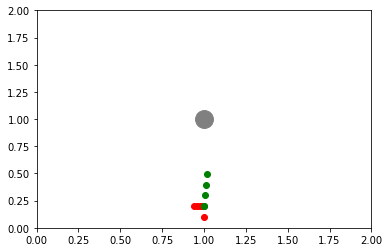

In [195]:
import imageio
import os

for filename in os.listdir('./figs/'):
    os.remove('./figs/' + filename)
for i in range(len(toSaveRed[0])):
    plt.clf()
    plt.axis([0,Lx,0,Ly])
    plt.scatter(toSaveRed[0][max(0, i - 5) : i : 1],toSaveRed[1][max(0, i - 5) : i : 1], color='red')
    plt.scatter([x0], [y0], color='gray', s=20*16)
    plt.scatter(toSaveGreen[0][max(0, i - 5) : i : 1],toSaveGreen[1][max(0, i - 5) : i : 1], color='green')
    num = ''
    if i < 10:
        num = '00' + str(i)
    elif i < 100:
        num = '0' + str(i)
    else:
        num = str(i)
    plt.savefig('./figs/' + num + '.png')
with imageio.get_writer('plot.gif', mode='I') as writer:
    filenames = os.listdir('./figs/')
    filenames.sort()
    for filename in filenames:
        writer.append_data(imageio.imread('./figs/' + filename))